<a href="https://colab.research.google.com/github/riccardobermeo/Lab_Econ_I/blob/master/Fraude_Canastas_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Colegio Bourbaki](./Images/Bourbaki.png)

##  Rudimentos de Machine Learning

NP Paribas Personal Finance es líder en financiación personal en Francia y en Europa a través de su actividad de crédito al consumo. Filial al 100% del Grupo BNP Paribas, BNP Paribas Personal Finance reúne a más de 20 000 empleados y opera en una treintena de países. Bajo diversas marcas como Cetelem, Cofinoga y Findomestic, BNP Paribas Personal Finance ofrece a sus clientes una gama completa de créditos al consumo, disponibles en tiendas y concesionarios de automóviles o directamente a través de centros de relación con el cliente y de los sitios web locales de la empresa.

BNP Paribas Personal Finance ha desarrollado una estrategia activa de apoyo a los minoristas, fabricantes y concesionarios de automóviles, comerciantes Web y diversas instituciones financieras (banca y seguros), basada en su experiencia en el mercado de crédito y su capacidad para ofrecer servicios adaptados a la actividad y la estrategia comercial de sus socios comerciales. También es un actor clave en materia de crédito responsable y de concienciación presupuestaria.

BNPP Personal Finance está, por naturaleza, expuesta al Riesgo de Crédito, y se basa en gran medida en modelos cuantitativos para gestionarlo. Dentro de BNP Paribas Personal Finance, el Departamento Central de Riesgos es responsable de la pertinencia de los modelos de calificación de riesgos utilizados en todas las entidades locales y de mantener un alto nivel de experiencia en la integración de nuevas técnicas estadísticas en nuevos entornos de modelización.

El equipo de Optimización de Procesos de Crédito forma parte del departamento de RIESGO de BNPP PF, dentro de Risk Personal Finance Global Credit Decision-making Policies, contribuimos a la racionalización y la optimización de los procesos de decisión de riesgo a través de un enfoque analítico. Apoyamos a los equipos de riesgo locales para mejorar la eficiencia de los procesos de crédito, incluida la parte de fraude, participando en el mejor equilibrio entre rentabilidad, recorrido del cliente y perfiles de riesgo.

**El fraude es un problema importante para los comerciantes. Los delincuentes utilizan una amplia variedad de métodos para atacar a las organizaciones a través de sistemas, canales, procesos y productos. Por ello, el desarrollo de métodos de detección del fraude reviste una importancia crucial. La detección del fraude es un problema difícil porque los defraudadores hacen todo lo posible para que su comportamiento parezca legítimo. Otra dificultad es que el número de registros legítimos es mucho mayor que el número de casos fraudulentos.**

**En nuestro caso, trabajeremos con un data ya pre-procesado para poder realizar el modelo de perceptron y regresión logística**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### Librerias

In [59]:
# Data Analysis
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Classificaon
from sklearn.linear_model import Perceptron, LogisticRegression

#Utils
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split

#Standars
from sklearn.preprocessing import StandardScaler

### Funciones de ayuda

In [3]:
def high_correlation_features(dataframe, threshold=0.95):
    """
    Identifies and returns pairs of highly correlated features from the given dataframe.

    Parameters:
    - dataframe: A pandas DataFrame containing the dataset.
    - threshold: A float representing the correlation threshold to identify high correlations.

    Returns:
    - A DataFrame with pairs of features that have a correlation coefficient above the threshold.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr()

    # Find features with a correlation above the threshold
    # Note: The matrix is symmetric, so we need to filter out one side to avoid duplicates
    high_corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                       .stack()
                       .reset_index())
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['Correlation'] > threshold, :]

    return high_corr_pairs


In [4]:
def remove_highly_correlated_features(dataframe, threshold=0.95):
    """
    Removes features that are highly correlated with each other above a specified threshold.

    Parameters:
    - dataframe: A pandas DataFrame containing the dataset.
    - threshold: A float representing the correlation threshold to identify high correlations.

    Returns:
    - A DataFrame with the highly correlated features removed.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr().abs()

    # Select upper triangle of correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    # Drop features
    reduced_df = dataframe.drop(to_drop, axis=1)

    return reduced_df, to_drop


In [5]:
def plot_correlation_matrix(dataframe, plot_graph=True, return_matrix=False):
    """
    Calculates and optionally plots the correlation matrix of a given DataFrame.

    Parameters:
    - dataframe: DataFrame from which to calculate the correlation matrix.
    - plot_graph: If True, displays a heatmap of the correlation matrix.
    - return_matrix: If True, returns the correlation matrix.

    Returns:
    - If return_matrix is True, returns the correlation matrix of the dataframe.
    """
    # Calculate the correlation matrix
    correlation_matrix = dataframe.corr('spearman')

    # Plot the correlation matrix heatmap if requested
    if plot_graph:
        plt.figure(figsize=(25, 20))
        sns.heatmap(correlation_matrix, vmin=-1, vmax=1, center=0, cmap="hot", annot=True, fmt=".2f", square=True)
        plt.xticks(rotation=45, horizontalalignment='right')

    # Return the correlation matrix if requested
    if return_matrix:
        return correlation_matrix

In [6]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap.

    Parameters:
    - y_true: array-like of shape (n_samples,), True labels of the data.
    - y_pred: array-like of shape (n_samples,), Predicted labels.

    Returns:
    - None, displays a confusion matrix.
    """
    # Compute confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)

    # Create a DataFrame for Seaborn's heatmap
    confusion_df = pd.DataFrame(confusion_mat, index=['Real Negative', 'Real Positive'], columns=['Predicted Negative', 'Predicted Positive'])

    # Plotting the heatmap
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [7]:
def plot_roc_curve(clf, X_test, y_test, figsize=(10, 7)):
    """
    Plots the ROC curve by handling classifiers with or without the `predict_proba` method.
    Uses `decision_function` or binary predictions as fallbacks.

    Parameters:
    - clf: Classifier to evaluate.
    - X_test: Test data features.
    - y_test: True labels for the test data.
    - figsize: Size of the plot.
    """

    try:
        # First try to use predict_proba
        y_scores = clf.predict_proba(X_test)[:, 1]
    except AttributeError:
        try:
            # Next, try to use decision_function
            y_scores = clf.decision_function(X_test)
            # Convert decision scores to probabilities (min-max scaling)
            y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
        except AttributeError:
            # As a last resort, use binary predictions
            # This approach lacks precision and should be used cautiously
            y_pred = clf.predict(X_test)
            y_scores = np.where(y_pred == 1, 1, 0)  # Assuming the positive class is labeled as 1

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()




### Carga de Datos

In [34]:
#df = pd.read_csv('./drive/MyDrive/Data/FraudeCanastas.csv') #Colab
df = pd.read_csv('dataset_reto12.txt', sep=',')#, on_bad_lines='skip') #Colab

In [35]:
numero_columnas = df.shape[1]
numero_columnas
df.shape

(6413, 2457)

In [36]:
#Observamos el dataFrame cargado
df.head()

,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
0,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,3.0,1066.0,355.333333,929.0,17.0,0.0
1,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,1299.0,649.500000,1299.0,0.0,1.0
2,132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,774.0,387.000000,774.0,0.0,0.0
3,137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,786.0,393.000000,779.0,7.0,0.0
4,153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,449.0,224.500000,409.0,40.0,0.0


In [37]:
#Revisamos que todos los datos se hayan cargado correctamente
df.tail()

,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
6408,115840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,2024.0,1012.000000,1999.0,25.0,0.0
6409,115866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1649.0,1649.000000,1649.0,1649.0,0.0
6410,115874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1319.0,1319.000000,1319.0,1319.0,0.0
6411,115891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,3.0,1424.0,474.666667,1259.0,25.0,0.0
6412,115935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,569.0,569.000000,569.0,569.0,0.0


In [38]:
#Las columnas nos diran como estan divididos los productos y clasificaciones para analizar el fraude
df.columns

Index(['ID', 'APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90',
       'AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H',
       'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE',
       'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI',
       'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE',
       'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND',
       'AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD',
       'AUDIO ACCESSORIES | APPLE | AIRPODS PRO',
       'AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX',
       ...
       'WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY',
       'WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT',
       'WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10',
       'Nb_of_items', 'total_of_items', 'costo_tot

In [40]:
df = df.set_index('ID')

In [41]:
df.head()

,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX NOISE CANCELLING WIRELESS BLUETO,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
ID,,,,,,,,,,,,,,,,,,,,,
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,3.0,1066.0,355.333333,929.0,17.0,0.0
130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,1299.0,649.500000,1299.0,0.0,1.0
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,774.0,387.000000,774.0,0.0,0.0
137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,786.0,393.000000,779.0,7.0,0.0
153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,449.0,224.500000,409.0,40.0,0.0


In [42]:
#Analisis estadístico descriptivo de las variables númericas
df.describe()

,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX NOISE CANCELLING WIRELESS BLUETO,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
count,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,6413.000000,...,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000
mean,0.155933,0.003119,0.327616,0.201154,0.074068,0.021675,0.373928,0.273663,0.513644,2.044909,...,0.004367,0.002807,0.004055,1.767779,1.851528,1364.630536,912.726068,1205.254367,656.568153,0.184186
std,12.487324,0.249746,8.347665,4.654476,3.428119,1.735738,7.729049,7.300526,16.786028,32.133361,...,0.349672,0.224789,0.324696,1.430075,1.801084,1101.331260,740.841658,794.282679,851.325464,0.387666
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,219.000000,41.838710,130.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,856.000000,449.000000,749.000000,7.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1149.000000,749.000000,1099.000000,389.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,2.000000,1660.500000,1170.500000,1495.000000,1099.000000,0.000000
max,1000.000000,20.000000,500.000000,119.000000,168.000000,139.000000,169.000000,195.000000,549.000000,549.000000,...,28.000000,18.000000,26.000000,38.000000,40.000000,24551.000000,19999.000000,19999.000000,19999.000000,1.000000


In [47]:
#Buscamos la presencia de valores nulos
print(f'Los valores nulos son {sum(df.isnull().sum())}')

Los valores nulos son 2361


In [48]:
filas_con_nulos = df[df.isnull().any(axis=1)]
filas_con_nulos

,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX NOISE CANCELLING WIRELESS BLUETO,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
ID,,,,,,,,,,,,,,,,,,,,,
79389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#Quitamos el registro con valores nulos
df = df.dropna()

In [51]:
# Distribution of the fraud flag
fraud_distribution = df['fraud_flag'].value_counts(normalize=True) * 100

In [52]:
fraud_distribution

fraud_flag
0.0    81.58141
1.0    18.41859
Name: proportion, dtype: float64

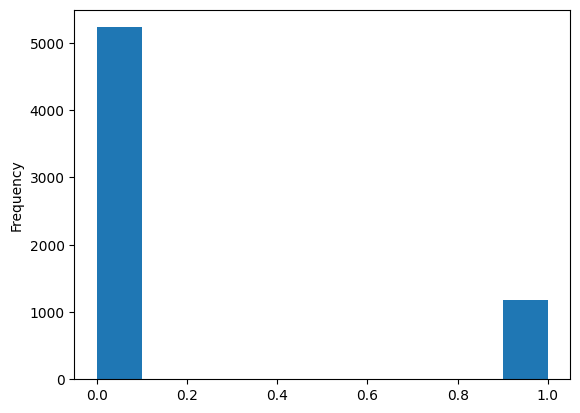

In [53]:
df['fraud_flag'].plot(kind='hist')
plt.show()

Vamos a ver correlaciones entre las caracteristicas:

In [54]:
#Buscamos variables altamente correlacionadas
high_corr_features_df = high_correlation_features(df, 0.99)

In [55]:
#Quitamos las variables altamente correlacionadas
df, _ = remove_highly_correlated_features(df, 0.99)

In [56]:
#Separar las etiquetas del conjunto de datos
X = df.drop('fraud_flag', axis=1)
y = df['fraud_flag']

In [61]:
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

In [62]:
# Standarize training and test datasets
scaler = StandardScaler().fit(X_train_unscaled) # Guardamos la escla para predicciones
X_train = scaler.transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

In [63]:
# imprime los conjuntos de entrenamiento y prueba
print("TRAINING SET")
print("X: ", X_train.shape)
print("y: ", y_train.shape)
print('Fraude:{:7.3f}%'.format(y_train.mean()*100),'\n')

print("TEST SET")
print("X: ", X_test.shape)
print("y: ", y_test.shape)
print('Fraude:{:7.3f}%'.format(y_test.mean()*100))

TRAINING SET
X:  (5129, 1796)
y:  (5129,)
Fraude: 18.152% 

TEST SET
X:  (1283, 1796)
y:  (1283,)
Fraude: 19.486%


Vamos a entrenar un Perceptrón:

In [64]:
model = Perceptron(max_iter=100, random_state=42, verbose=True, class_weight='balanced')

In [65]:
model.fit(X_train, y_train)

-- Epoch 1
Norm: 1199.30, NNZs: 1028, Bias: -80.541170, T: 5129, Avg. loss: 62.539852
Total training time: 0.05 seconds.
-- Epoch 2
Norm: 1433.92, NNZs: 1028, Bias: -168.280430, T: 10258, Avg. loss: 73.979024
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 1459.38, NNZs: 1028, Bias: -243.557875, T: 15387, Avg. loss: 62.597824
Total training time: 0.10 seconds.
-- Epoch 4
Norm: 1506.27, NNZs: 1028, Bias: -241.841357, T: 20516, Avg. loss: 56.724973
Total training time: 0.13 seconds.
-- Epoch 5
Norm: 1500.99, NNZs: 1028, Bias: -273.712422, T: 25645, Avg. loss: 56.255044
Total training time: 0.16 seconds.
-- Epoch 6
Norm: 1535.35, NNZs: 1028, Bias: -274.405984, T: 30774, Avg. loss: 51.400867
Total training time: 0.19 seconds.
-- Epoch 7
Norm: 1567.01, NNZs: 1028, Bias: -267.757758, T: 35903, Avg. loss: 60.038120
Total training time: 0.24 seconds.
-- Epoch 8
Norm: 1542.24, NNZs: 1028, Bias: -281.635569, T: 41032, Avg. loss: 57.481063
Total training time: 0.27 seconds.
-- Epoch 9
Norm: 1

Perceptron(class_weight='balanced', max_iter=100, random_state=42, verbose=True)

In [66]:
y_pred = model.predict(X_test)

Veamos las métricas del modelo:

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      1033
         1.0       0.42      0.66      0.51       250

    accuracy                           0.76      1283
   macro avg       0.66      0.72      0.68      1283
weighted avg       0.81      0.76      0.77      1283



In [68]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 76.53%
Precisión conjunto prueba: 75.60%


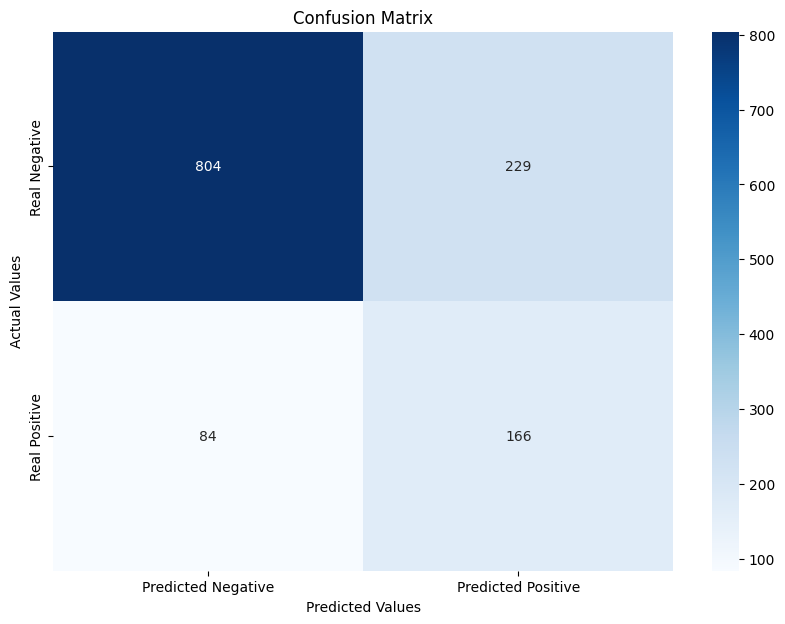

In [69]:
plot_confusion_matrix(y_test, y_pred)

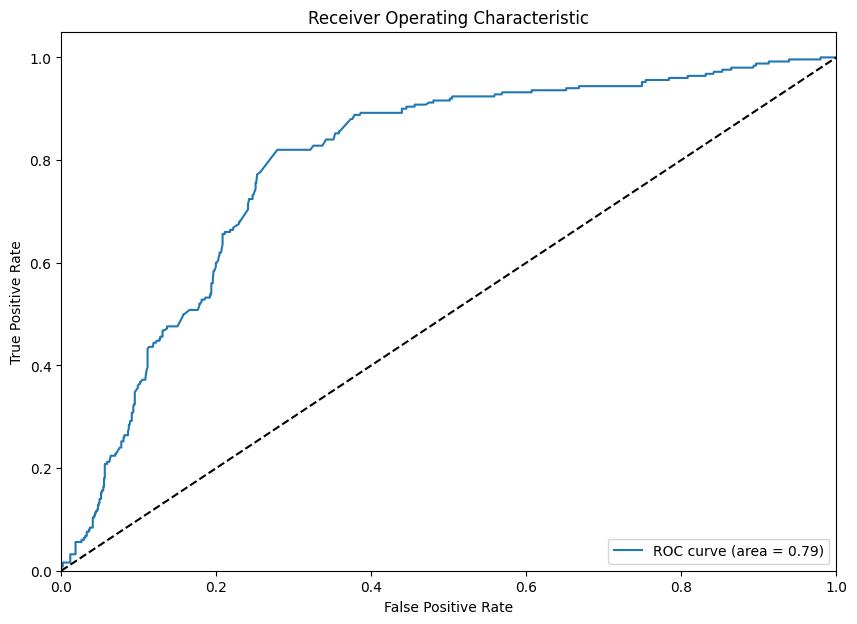

In [70]:
plot_roc_curve(model, X_test, y_test)

Veamos ahora la clasificación con Perceptron con margen:

In [71]:
model_margin = Perceptron(penalty='l2', max_iter=100, random_state=42, verbose=True, alpha=0.00005)

In [72]:
model_margin.fit(X_train,y_train)

-- Epoch 1
Norm: 1228.35, NNZs: 1028, Bias: -558.000000, T: 5129, Avg. loss: 39.473137
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 1030.22, NNZs: 1028, Bias: -463.000000, T: 10258, Avg. loss: 26.093498
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 860.81, NNZs: 1028, Bias: -396.000000, T: 15387, Avg. loss: 20.808315
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 712.18, NNZs: 1028, Bias: -337.000000, T: 20516, Avg. loss: 20.618807
Total training time: 0.10 seconds.
-- Epoch 5
Norm: 602.12, NNZs: 1028, Bias: -291.000000, T: 25645, Avg. loss: 21.850095
Total training time: 0.12 seconds.
-- Epoch 6
Norm: 517.66, NNZs: 1028, Bias: -241.000000, T: 30774, Avg. loss: 20.694376
Total training time: 0.14 seconds.
-- Epoch 7
Norm: 437.72, NNZs: 1028, Bias: -220.000000, T: 35903, Avg. loss: 20.598040
Total training time: 0.16 seconds.
-- Epoch 8
Norm: 376.69, NNZs: 1028, Bias: -183.000000, T: 41032, Avg. loss: 19.731153
Total training time: 0.18 seconds.
-- Epoch 9
Norm: 327.99

Perceptron(alpha=5e-05, max_iter=100, penalty='l2', random_state=42,
           verbose=True)

In [73]:
y_pred = model_margin.predict(X_test)

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      1033
         1.0       0.41      0.39      0.40       250

    accuracy                           0.77      1283
   macro avg       0.63      0.63      0.63      1283
weighted avg       0.77      0.77      0.77      1283



In [75]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_margin.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_margin.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 80.05%
Precisión conjunto prueba: 77.01%


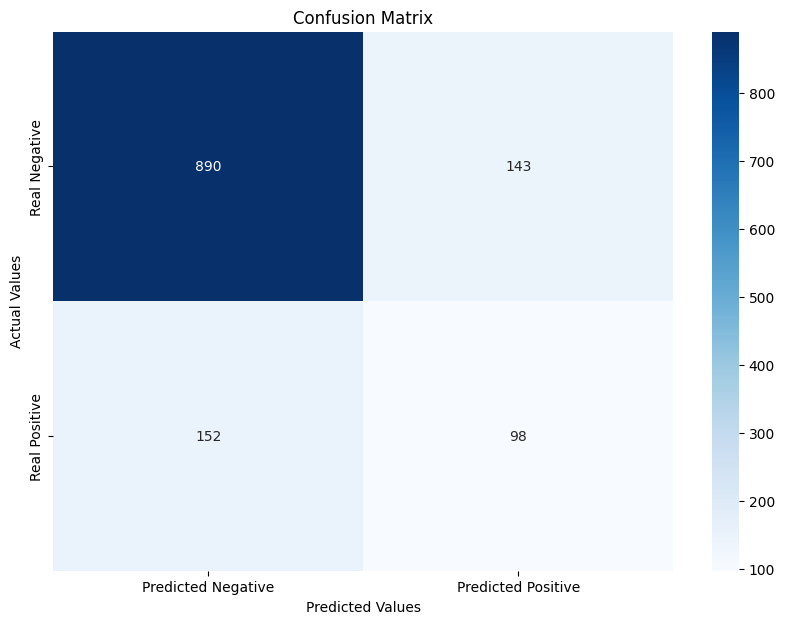

In [76]:
plot_confusion_matrix(y_test, y_pred)

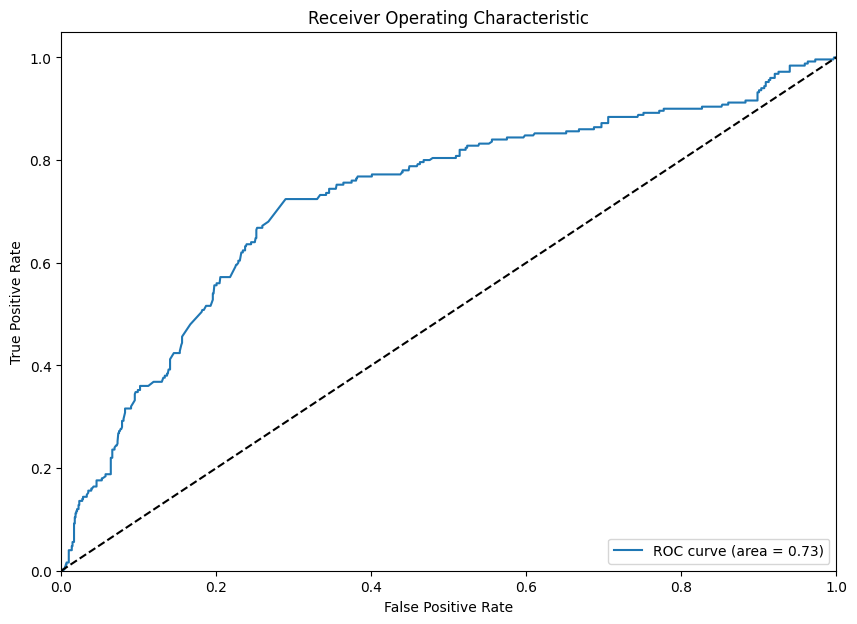

In [77]:
plot_roc_curve(model_margin, X_test, y_test)

In [78]:
model_margin_1 = Perceptron(penalty='l2', max_iter=100, random_state=42, verbose=True, alpha=0.0005)

In [79]:
model_margin_1.fit(X_train,y_train)

-- Epoch 1
Norm: 329.12, NNZs: 1028, Bias: -91.000000, T: 5129, Avg. loss: 21.327744
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 241.59, NNZs: 1028, Bias: -38.000000, T: 10258, Avg. loss: 16.629569
Total training time: 0.05 seconds.
-- Epoch 3
Norm: 263.82, NNZs: 1028, Bias: -48.000000, T: 15387, Avg. loss: 17.251672
Total training time: 0.07 seconds.
-- Epoch 4
Norm: 304.23, NNZs: 1028, Bias: -43.000000, T: 20516, Avg. loss: 16.726946
Total training time: 0.09 seconds.
-- Epoch 5
Norm: 296.06, NNZs: 1028, Bias: -50.000000, T: 25645, Avg. loss: 18.339681
Total training time: 0.12 seconds.
-- Epoch 6
Norm: 275.78, NNZs: 1028, Bias: -24.000000, T: 30774, Avg. loss: 15.102902
Total training time: 0.14 seconds.
-- Epoch 7
Norm: 305.93, NNZs: 1028, Bias: -44.000000, T: 35903, Avg. loss: 17.526575
Total training time: 0.16 seconds.
-- Epoch 8
Norm: 336.00, NNZs: 1028, Bias: -64.000000, T: 41032, Avg. loss: 17.369191
Total training time: 0.19 seconds.
-- Epoch 9
Norm: 323.34, NNZs: 10

Perceptron(alpha=0.0005, max_iter=100, penalty='l2', random_state=42,
           verbose=True)

In [80]:
y_pred = model_margin_1.predict(X_test)

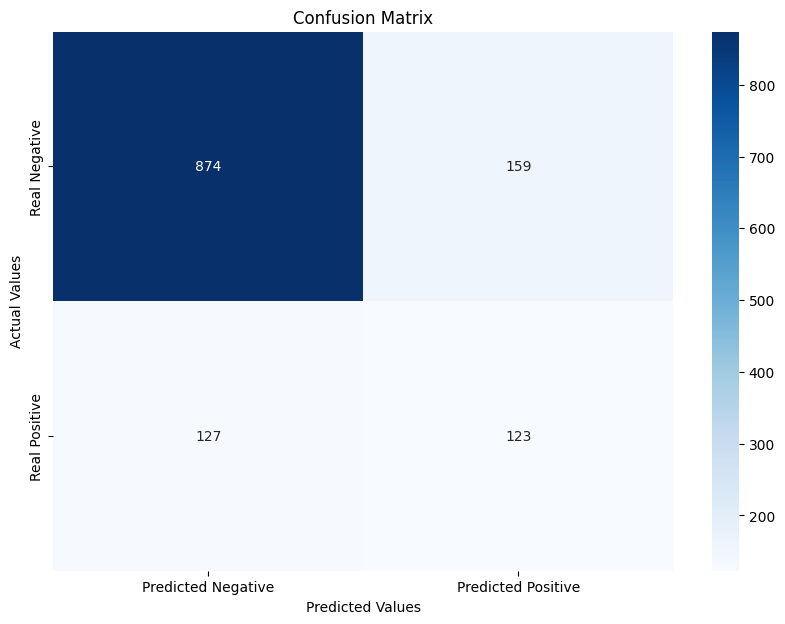

In [81]:
plot_confusion_matrix(y_test, y_pred)

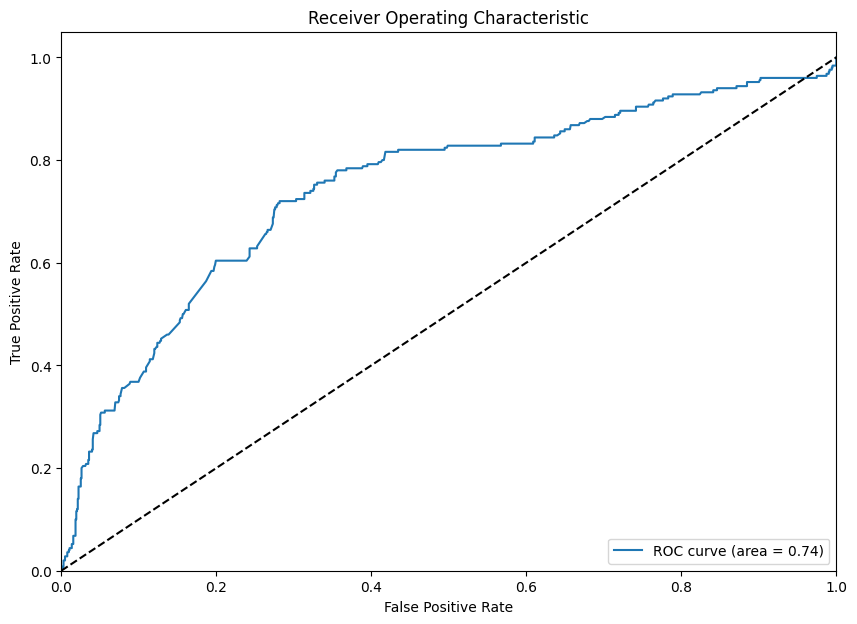

In [82]:
plot_roc_curve(model_margin_1, X_test, y_test)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      1033
         1.0       0.44      0.49      0.46       250

    accuracy                           0.78      1283
   macro avg       0.65      0.67      0.66      1283
weighted avg       0.79      0.78      0.78      1283



In [84]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_margin_1.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_margin_1.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 78.20%
Precisión conjunto prueba: 77.71%


In [85]:
model_margin_2 = Perceptron(penalty='l2', max_iter=100, random_state=42, verbose=True, alpha=0.005)

In [86]:
model_margin_2.fit(X_train,y_train)

-- Epoch 1
Norm: 149.12, NNZs: 1028, Bias: -12.000000, T: 5129, Avg. loss: 7.226567
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 115.72, NNZs: 1028, Bias: -6.000000, T: 10258, Avg. loss: 7.200458
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 91.72, NNZs: 1028, Bias: -13.000000, T: 15387, Avg. loss: 7.171852
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 146.37, NNZs: 1028, Bias: -21.000000, T: 20516, Avg. loss: 6.790437
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 127.77, NNZs: 1028, Bias: -8.000000, T: 25645, Avg. loss: 7.700498
Total training time: 0.16 seconds.
-- Epoch 6
Norm: 118.90, NNZs: 1028, Bias: -10.000000, T: 30774, Avg. loss: 7.280887
Total training time: 0.19 seconds.
-- Epoch 7
Norm: 109.36, NNZs: 1028, Bias: -20.000000, T: 35903, Avg. loss: 7.571400
Total training time: 0.22 seconds.
-- Epoch 8
Norm: 98.95, NNZs: 1028, Bias: -14.000000, T: 41032, Avg. loss: 6.448634
Total training time: 0.25 seconds.
-- Epoch 9
Norm: 82.59, NNZs: 1028, Bias: -11

Perceptron(alpha=0.005, max_iter=100, penalty='l2', random_state=42,
           verbose=True)

In [87]:
y_pred = model_margin_2.predict(X_test)

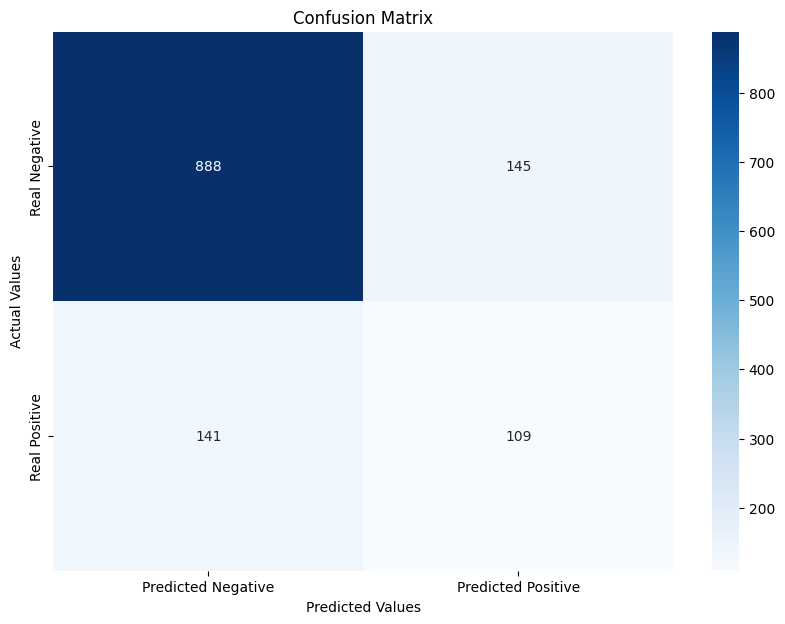

In [88]:
plot_confusion_matrix(y_test, y_pred)

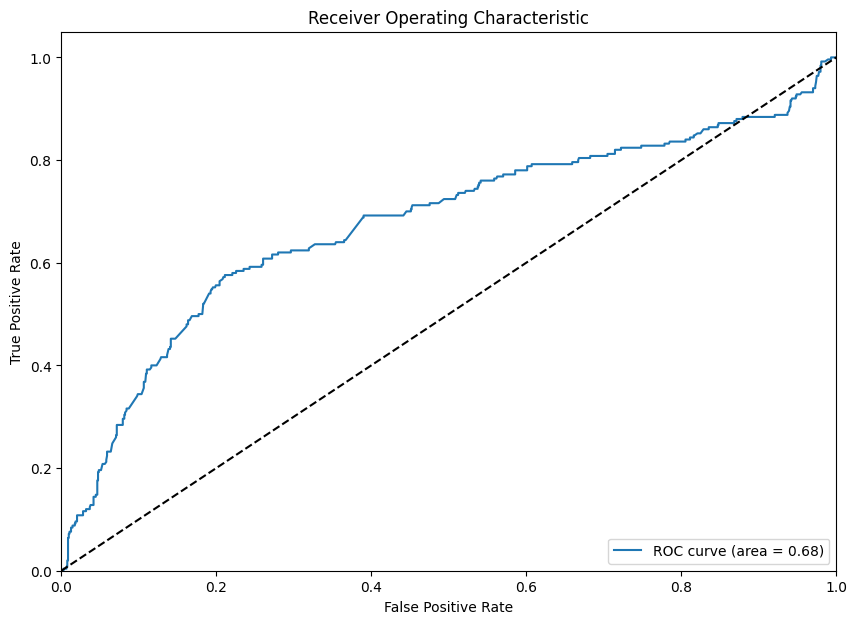

In [89]:
plot_roc_curve(model_margin_2, X_test, y_test)

In [90]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_margin_2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_margin_2.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 78.65%
Precisión conjunto prueba: 77.71%


Veamos otros ejemplos:

In [91]:
model_new = Perceptron(max_iter=1000, verbose=True, penalty='elasticnet', alpha=0.0005, l1_ratio=0.5, shuffle=True, eta0=1e-3, early_stopping=True, validation_fraction=0.1, class_weight='balanced')

Note: A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression. The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features.

In [92]:
model_new.fit(X_train,y_train)

-- Epoch 1
Norm: 1.11, NNZs: 1019, Bias: -0.170809, T: 4616, Avg. loss: 0.050337
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 1.40, NNZs: 708, Bias: -0.127008, T: 9232, Avg. loss: 0.065569
Total training time: 0.14 seconds.
-- Epoch 3
Norm: 1.51, NNZs: 686, Bias: -0.130579, T: 13848, Avg. loss: 0.057204
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 1.49, NNZs: 689, Bias: -0.122543, T: 18464, Avg. loss: 0.057792
Total training time: 0.37 seconds.
-- Epoch 5
Norm: 1.50, NNZs: 682, Bias: -0.132567, T: 23080, Avg. loss: 0.042226
Total training time: 0.52 seconds.
-- Epoch 6
Norm: 1.55, NNZs: 683, Bias: -0.109592, T: 27696, Avg. loss: 0.040331
Total training time: 0.70 seconds.
-- Epoch 7
Norm: 1.57, NNZs: 681, Bias: -0.109764, T: 32312, Avg. loss: 0.049152
Total training time: 0.86 seconds.
-- Epoch 8
Norm: 1.59, NNZs: 669, Bias: -0.097508, T: 36928, Avg. loss: 0.043313
Total training time: 1.04 seconds.
Convergence after 8 epochs took 1.05 seconds


Perceptron(alpha=0.0005, class_weight='balanced', early_stopping=True,
           eta0=0.001, l1_ratio=0.5, penalty='elasticnet', verbose=True)

In [93]:
y_pred_new = model_new.predict(X_test)

In [94]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

         0.0       0.92      0.61      0.73      1033
         1.0       0.33      0.79      0.46       250

    accuracy                           0.64      1283
   macro avg       0.63      0.70      0.60      1283
weighted avg       0.81      0.64      0.68      1283



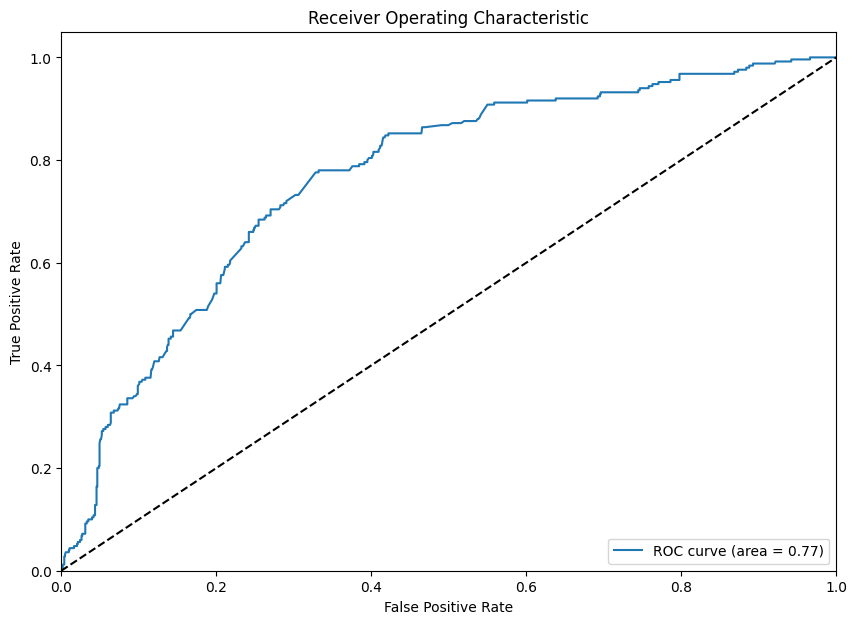

In [95]:
plot_roc_curve(model_new, X_test, y_test)

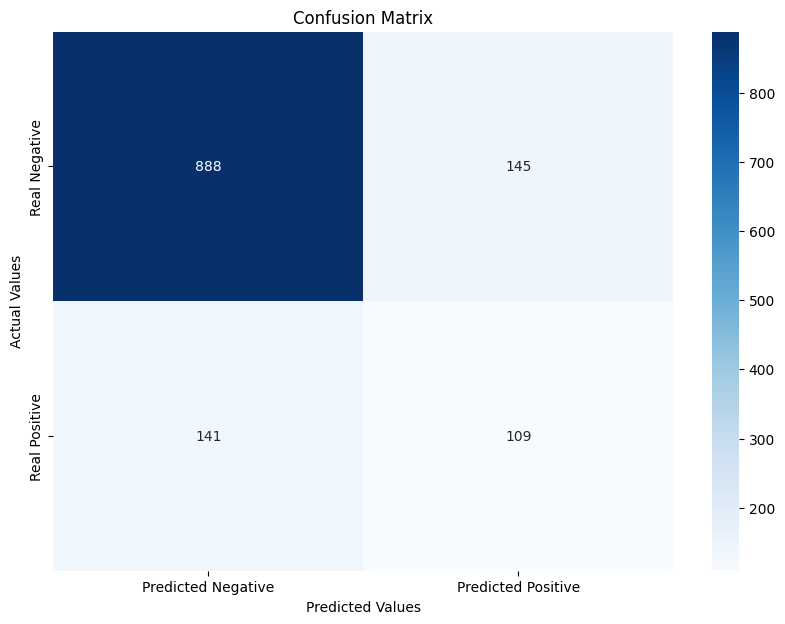

In [96]:
plot_confusion_matrix(y_test, y_pred)

In [97]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_new.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_new.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 65.39%
Precisión conjunto prueba: 64.46%


Hagamos una búsqueda grillada:

In [98]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    # 'max_iter': [1000],
    # 'penalty': ['elasticnet'],
    'alpha': [1e-5, 1e-4, 1e-3],
    'l1_ratio': [0, 0.15, 0.25, 0.5, 0.75, 0.85, 1],
    # 'shuffle': [True],
    'eta0': [1e-5, 1e-3, 1e-1, 1],
    # 'early_stopping': [True],
    # 'validation_fraction': [0.05, 0.15],
    'class_weight': ['balanced', None, {0:1,1:3}, {0:1,1:2.5}, {0:1,1:2}, {0:1,1:1.5}]
}

# Initialize the Perceptron model
model = Perceptron(penalty='elasticnet', max_iter=1000, random_state=42, verbose=False, shuffle=True)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=6, verbose=0,
                           scoring=['recall', 'accuracy'], refit='recall',
                           return_train_score=True)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print('=======================================================')
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'alpha': 0.001, 'class_weight': 'balanced', 'eta0': 0.001, 'l1_ratio': 0}
Best Cross-Validation Score: 0.7400609510666436


In [99]:
model_grid = Perceptron(**best_params)

In [100]:
model_grid.fit(X_train, y_train)

Perceptron(alpha=0.001, class_weight='balanced', eta0=0.001, l1_ratio=0)

In [101]:
y_pred_grid = model_grid.predict(X_test)

In [102]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81      1033
         1.0       0.39      0.66      0.49       250

    accuracy                           0.73      1283
   macro avg       0.64      0.70      0.65      1283
weighted avg       0.80      0.73      0.75      1283



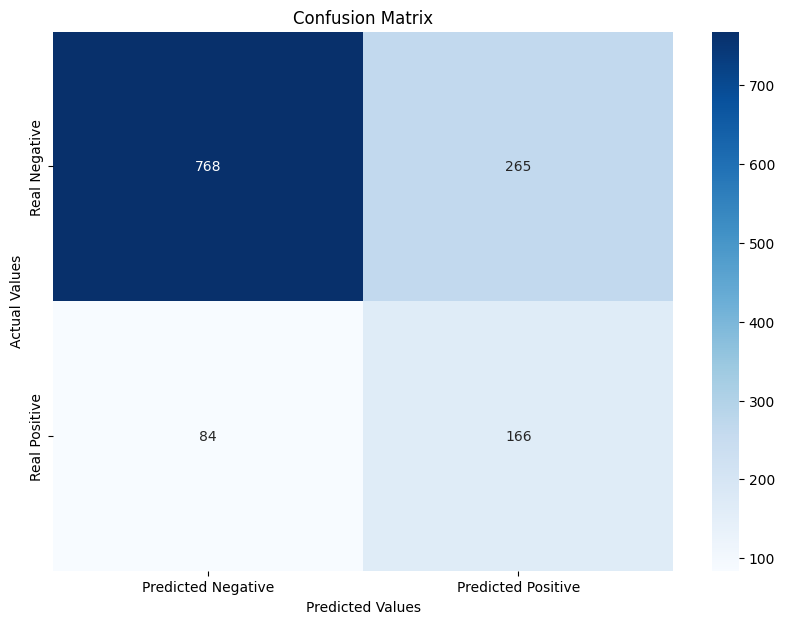

In [103]:
plot_confusion_matrix(y_test, y_pred_grid)

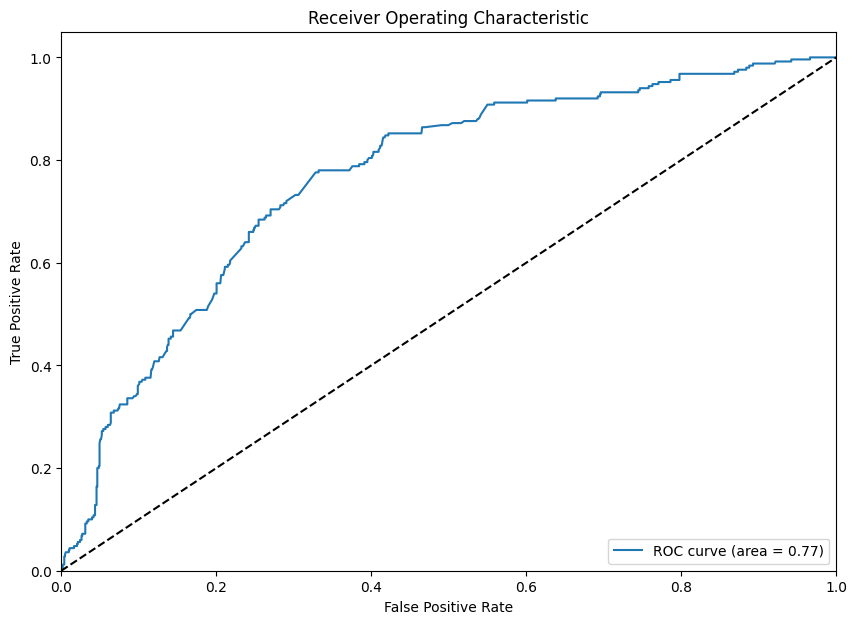

In [104]:
plot_roc_curve(model_new, X_test, y_test)

In [105]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_grid.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_grid.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 74.52%
Precisión conjunto prueba: 72.80%


**Conclusiones del Modelo Perceptron:**

El modelo tiene una exactitud del 73% en el conjunto de prueba, lo cual es razonable pero no excelente.

**Desempeño por Clases:**

La clase 0 (mayoría) tiene un buen desempeño con alta precisión (0.90) y un F1-score (0.81).
La clase 1 (minoría) tiene un desempeño mucho peor, con una precisión baja (0.39) y un F1-score bajo (0.49). Esto sugiere que el modelo tiene dificultades para clasificar correctamente la clase 1. Sin embargo, dado que este es un modelo de Fraudes, dado el enfoque y estrategía que se quiera seguir esto podría modificarse, por ejemplo si se busca controlar el mayor número de fraudes pudieramos cambiar el trasehold con el fin de tener una mayor capacidad para atacar el fraude, si el objetivo es no tirar las ventas a causa del fraude este modelo podría ser bueno dado los resultados de la clase 0. A partir de ello podemos encontrar un enfoque de acuerdo a la estrategía de la organización

**Balance de Clases:**

El modelo tiene un mejor desempeño en la clase mayoritaria (clase 0) que en la clase minoritaria (clase 1), lo que indica un desequilibrio en las clases que afecta el rendimiento del modelo.

**Macro vs. Promedio Ponderado:**

El macro promedio proporciona una media aritmética simple, mostrando un desempeño general bajo (0.65 en F1-score).
El promedio ponderado considera el soporte de cada clase, resultando en un F1-score más alto (0.75), lo que indica que el modelo se desempeña mejor en la clase con más instancias (clase 0).

Hemos disminuido los errores graves y tener un control sobre las predicciones correctas en los fraudes pero a expensas de tener un mayor número de falsos positivos.

Ejercicios:

* Realizar feature selection

* Optimizar el modelo del Perceptron.  Optar por la regularización L1 o L2.

* Comenzar el challenge desde cero y realizar el prepocesamiento. No necesariamente tienen que llegar al mismo preprocesamiento usado. Pueden tomar sus decisiones de compromiso como así lo deseen.

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)